In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
import pandas as pd
import utils
import matplotlib.pyplot as plt
#import VAE
#import scedar as sce

try: 
    data,scdata
except:
    data  =  pd.read_csv('/Users/dawnstear/desktop/chop_cellpred/data.csv')
    sclabels = data['Labels']
    scdata = data.drop(['Labels','TYPE'],axis=1)

DataObj = utils.Data(scdata,sclabels,drop_remainder=True)  

assert not np.any(np.isnan(scdata))
assert not np.any(np.isnan(sclabels))

maxval = np.amax(scdata)
scdata = (scdata+1e-7)/maxval
#print(np.shape(scdata))
#maxval = np.amax(scdata)
#scdata = np.divide(scdata,maxval)



/Users/dawnstear/desktop/tensorflow_update/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/dawnstear/desktop/tensorflow_update/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:

n_cells, n_dims= np.shape(scdata)
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = n_cells #mnist.train.num_examples
input_dim = n_dims   #mnist.train.images[0].shape[0]

#----------------------------------------------------#
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-3, batch_size=100, n_z=10):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z
        self.build()
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, input_dim])
        n_hidden_f1 = 512
        n_hidden_f2 = 384
        n_hidden_f3 = 256
        
        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, n_hidden_f1, scope='enc_fc1', activation_fn=tf.nn.elu,reuse=tf.AUTO_REUSE) # AUTOREUSE
        f2 = fc(f1, n_hidden_f2, scope='enc_fc2', activation_fn=tf.nn.elu,reuse=tf.AUTO_REUSE)
        f3 = fc(f2, n_hidden_f3, scope='enc_fc3', activation_fn=tf.nn.elu,reuse=tf.AUTO_REUSE)
        
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', activation_fn=None,reuse=tf.AUTO_REUSE)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma',reuse=tf.AUTO_REUSE, 
                                 activation_fn=None)
        
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, n_hidden_f3, scope='dec_fc1', activation_fn=tf.nn.elu,reuse=tf.AUTO_REUSE)
        g2 = fc(g1, n_hidden_f2, scope='dec_fc2', activation_fn=tf.nn.elu,reuse=tf.AUTO_REUSE)
        g3 = fc(g2, n_hidden_f1, scope='dec_fc3', activation_fn=tf.nn.elu,reuse=tf.AUTO_REUSE)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', activation_fn=tf.sigmoid,reuse=tf.AUTO_REUSE)

        # Loss: Reconstruction loss: Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1)
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)
        self.total_loss = tf.reduce_mean(recon_loss + latent_loss)
        self.train_op = tf.train.RMSPropOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, loss, recon_loss, latent_loss = self.sess.run(
            [self.train_op, self.total_loss, self.recon_loss, self.latent_loss],
            feed_dict={self.x: x}
        )
        return loss, recon_loss, latent_loss
    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat
    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z
    
#-------------------------------------#
        
def trainer(learning_rate=1e-3, batch_size=100, num_epoch=75, n_z=10):
    
    model = VariantionalAutoencoder(learning_rate=learning_rate,
                                    batch_size=batch_size, n_z=n_z)
    lossvec = []
    recon_lossvec = []
    latent_lossvec = []
    
    for epoch in range(num_epoch):
        for iter in range(num_sample // batch_size):
            # Obtian a batch
            batch = DataObj.train_batch(batch_size=batch_size)
            
            # Execute the forward and the backward pass and report computed losses
            loss, recon_loss, latent_loss = model.run_single_step(batch[0])
            
        lossvec = np.append(lossvec,loss)
        recon_lossvec = np.append(recon_lossvec,recon_loss)
        latent_lossvec = np.append(latent_lossvec,latent_loss)   
        
        if epoch % 5 == 0:
            print('[Epoch {}] Loss: {}, Recon loss: {}, Latent loss: {}'.format(
                epoch, loss, recon_loss, latent_loss))
    
    # *--------------- Plot Results -------------------*   
    fig, ax = plt.subplots()
    ax.plot(range(num_epoch),lossvec)
    ax.plot(range(num_epoch),recon_lossvec)
    ax.plot(range(num_epoch),latent_lossvec)
    ax.set(xlabel='Epoch', ylabel='Loss',title='Loss Over Training Phase') # include time//epoch//batch size in title
    ax.grid()
    print('Done!')
    return model



[Epoch 0] Loss: nan, Recon loss: nan, Latent loss: nan
[Epoch 5] Loss: nan, Recon loss: nan, Latent loss: nan
[Epoch 10] Loss: nan, Recon loss: nan, Latent loss: nan
[Epoch 15] Loss: nan, Recon loss: nan, Latent loss: nan
[Epoch 20] Loss: nan, Recon loss: nan, Latent loss: nan
[Epoch 25] Loss: nan, Recon loss: nan, Latent loss: nan
Done!


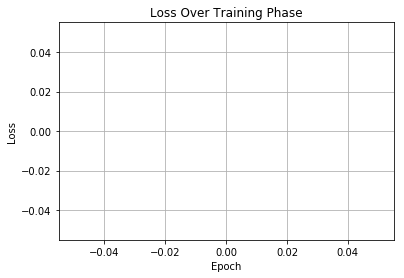

In [3]:
# Train the model
model = trainer(learning_rate=1e-8,  batch_size=100, num_epoch=26, n_z=2)
    

In [5]:
c = range(23)
c

range(0, 23)